<a href="https://colab.research.google.com/github/AbhilashDatta/SN-GAN/blob/main/SNGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spectrally Normalized Generative Adversarial Networks (SN-GAN)


**Goals**

In this notebook, we'll learn about and implement **spectral normalization**, a weight normalization technique to stabilize the training of the discriminator, as proposed in [Spectral Normalization for Generative Adversarial Networks](https://arxiv.org/abs/1802.05957) (Miyato et al. 2018).

**Background**

As its name suggests, SN-GAN normalizes the weight matrices in the discriminator by their corresponding [spectral norm](https://calculus.subwiki.org/wiki/Spectral_norm#:~:text=The%20spectral%20norm%20of%20a,where%20denotes%20the%20Euclidean%20norm.), which helps control the Lipschitz constant of the discriminator. As you have learned with WGAN, [Lipschitz continuity](https://en.wikipedia.org/wiki/Lipschitz_continuity) is important in ensuring the boundedness of the optimal discriminator. In the WGAN case, this makes it so that the underlying W-loss function for the discriminator (or more precisely, the critic) is valid.

As a result, spectral normalization helps improve stability and avoid vanishing gradient problems, such as mode collapse.

In [ ]:
# Some setup
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

'''
Function for visualizing images: Given a tensor of images, number of images, and
size per image, plots and prints the images in an uniform grid.
'''
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

### DCGAN Generator

Since spectral normalization is only applied to the matrices in the discriminator, the generator implementation is the same as the original.

In [ ]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
    z_dim: the dimension of the noise vector, a scalar
    im_chan: the number of channels of the output image, a scalar
            MNIST is black-and-white, so that's our default
    hidden_dim: the inner dimension, a scalar
    '''
    
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of the DCGAN, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation
        Parameters:
        input_channels: how many channels the input feature representation has
        output_channels: how many channels the output feature representation should have
        kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
        stride: the stride of the convolution
        final_layer: whether we're on the final layer (affects activation and batchnorm)
        '''
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else: # Final Layer
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the Generator: Given a noise vector, 
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
        noise: a noise tensor with dimensions (batch_size, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the Generator: Given a noise vector, 
        returns a generated image.
        Parameters:
        noise: a noise tensor with dimensions (batch_size, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating a noise vector: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
    n_samples: the number of samples in the batch, a scalar
    z_dim: the dimension of the noise vector, a scalar
    device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

### DCGAN Discriminator

For the discriminator, you can wrap each `nn.Conv2d` with `nn.utils.spectral_norm`. In the backend, this introduces parameters for $\tilde{u}$ and $\tilde{v}$ in addition to $W$ so that the $W_{SN}$ can be computed as $\tilde{u}^\top W\tilde{v}$ in runtime.

Pytorch also provides a `nn.utils.remove_spectral_norm` function, which collapses the 3 separate parameters into a single explicit $\overline{W}_{SN} := \tilde{u}^\top W\tilde{v}$. You should only apply this to your convolutional layers during inference to improve runtime speed.

It is important note that spectral norm does not eliminate the need for batch norm. Spectral norm affects the weights of each layer, while batch norm affects the activations of each layer. You can see both in a discriminator architecture, but you can also see just one of them. Hope this is something you have fun experimenting with!

In [ ]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
    im_chan: the number of channels of the output image, a scalar
            MNIST is black-and-white (1 channel), so that's our default.
    hidden_dim: the inner dimension, a scalar
    '''

    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of the DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation
        Parameters:
        input_channels: how many channels the input feature representation has
        output_channels: how many channels the output feature representation should have
        kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
        stride: the stride of the convolution
        final_layer: whether we're on the final layer (affects activation and batchnorm)
        '''
        
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.utils.spectral_norm(nn.Conv2d(input_channels, output_channels, kernel_size, stride)),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else: # Final Layer
            return nn.Sequential(
                nn.utils.spectral_norm(nn.Conv2d(input_channels, output_channels, kernel_size, stride)),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the Discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
        image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

### Training SN-DCGAN

You can now put everything together and train a spectrally normalized DCGAN! Here are all your parameters for initialization and optimization. 

In [ ]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 50
z_dim = 64
display_step = 500
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

# These parameters control the optimizer's momentum, which you can read more about here:
beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'

# We tranform our image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST(".", download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

Now, initialize the generator, the discriminator, and the optimizers.

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# We initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Finally, train the whole thing! And babysit those outputs :)

Step 500: Generator loss: 0.6946730136871333, discriminator loss: 0.6962362124919886


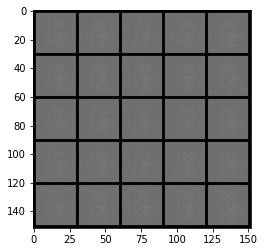

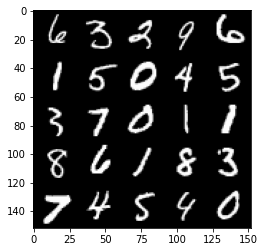

Step 1000: Generator loss: 0.6933944329023359, discriminator loss: 0.6932026219367984


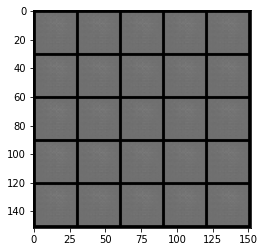

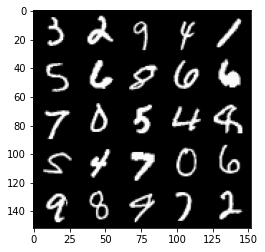

Step 1500: Generator loss: 0.6931636143922801, discriminator loss: 0.693211311817169


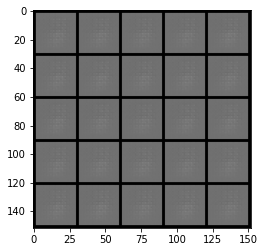

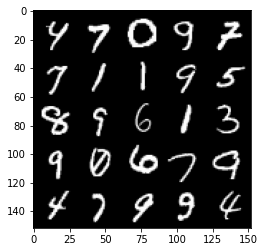

Step 2000: Generator loss: 0.6933526999950419, discriminator loss: 0.6931946679353718


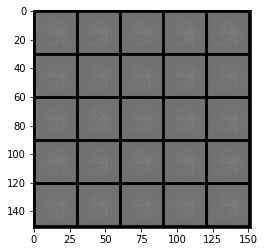

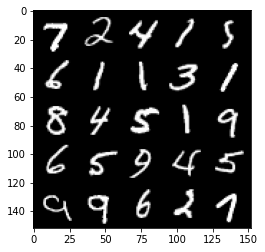

Step 2500: Generator loss: 0.6932461999654765, discriminator loss: 0.6931747521162032


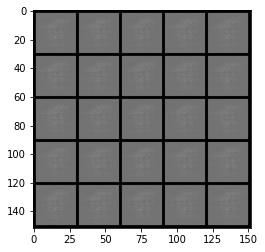

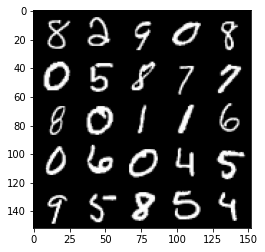

Step 3000: Generator loss: 0.6932137768268593, discriminator loss: 0.6931752851009378


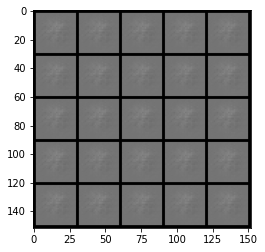

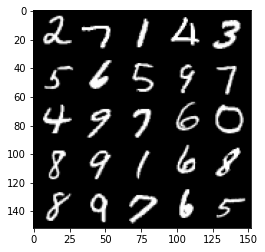

Step 3500: Generator loss: 0.6933309221267704, discriminator loss: 0.6931795084476478


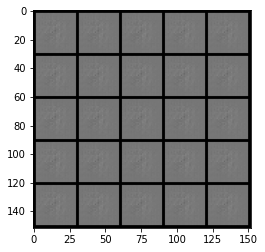

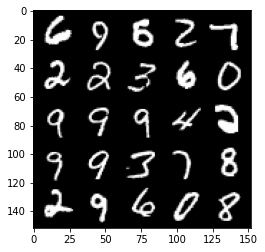

Step 4000: Generator loss: 0.6932500897645951, discriminator loss: 0.6931746891736981


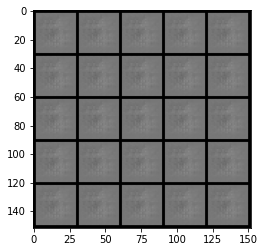

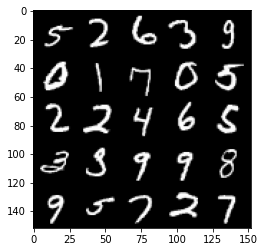

Step 4500: Generator loss: 0.6935900167226793, discriminator loss: 0.6932270765304558


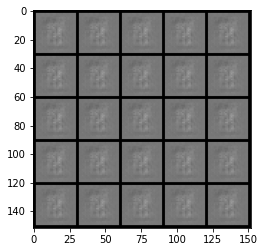

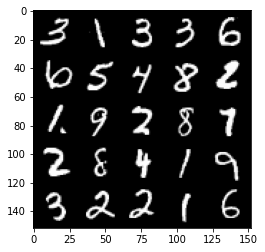

Step 5000: Generator loss: 0.6932320272922523, discriminator loss: 0.6931669917106639


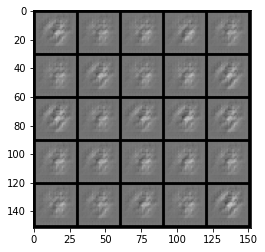

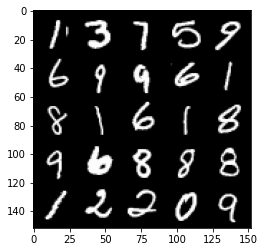

Step 5500: Generator loss: 0.7012829748392106, discriminator loss: 0.6898621658086775


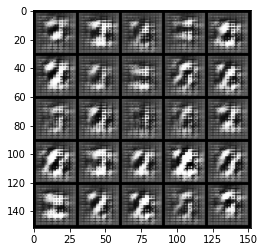

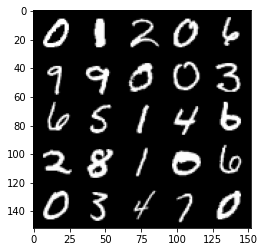

Step 6000: Generator loss: 0.7238466995954514, discriminator loss: 0.6816801527738567


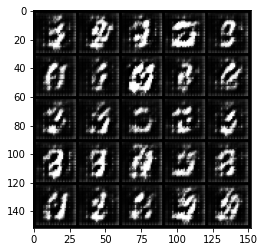

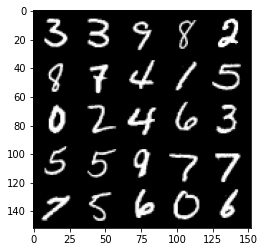

Step 6500: Generator loss: 0.7115810197591783, discriminator loss: 0.6897731877565377


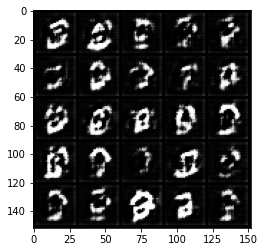

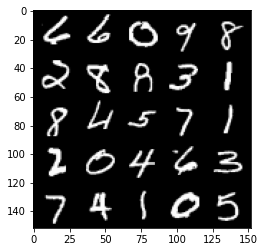

Step 7000: Generator loss: 0.7088571503162389, discriminator loss: 0.6841541739702222


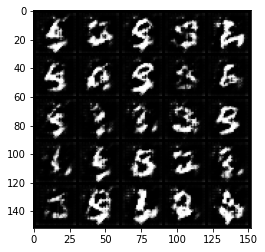

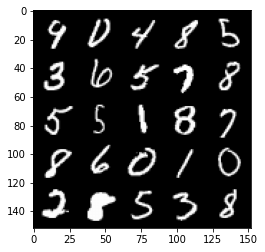

Step 7500: Generator loss: 0.7070556677579883, discriminator loss: 0.6856482486724853


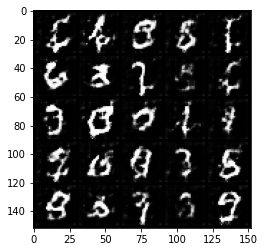

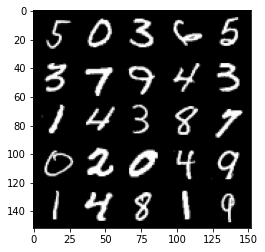

Step 8000: Generator loss: 0.7034776093959806, discriminator loss: 0.6876306806802749


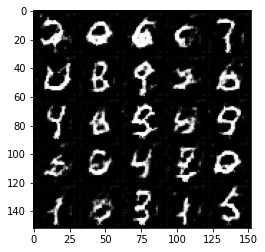

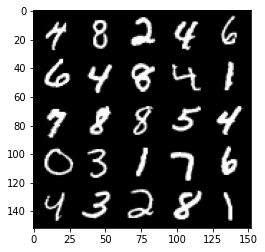

Step 8500: Generator loss: 0.7042100896835324, discriminator loss: 0.6883874782323838


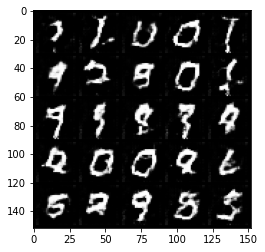

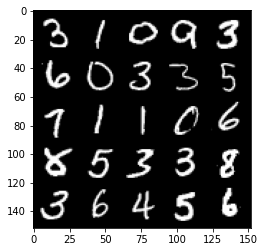

Step 9000: Generator loss: 0.7037733327150338, discriminator loss: 0.6886437200307842


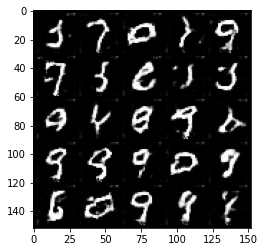

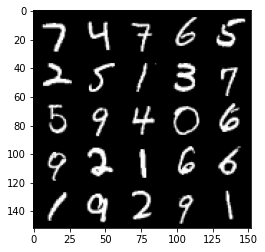

Step 9500: Generator loss: 0.7024347361326214, discriminator loss: 0.6892702183723455


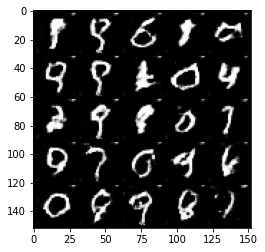

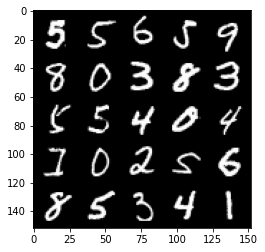

Step 10000: Generator loss: 0.7034043948650364, discriminator loss: 0.689337660908699


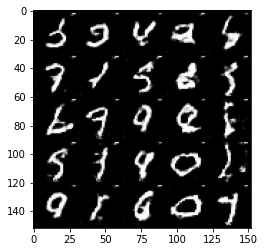

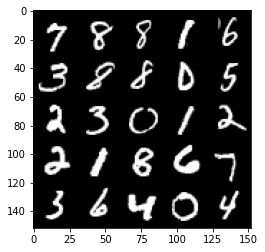

Step 10500: Generator loss: 0.7024281951189043, discriminator loss: 0.6894579591751103


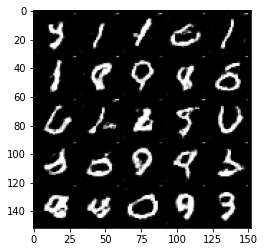

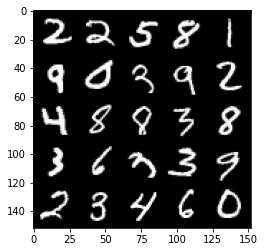

Step 11000: Generator loss: 0.7017939321994779, discriminator loss: 0.6902550169229503


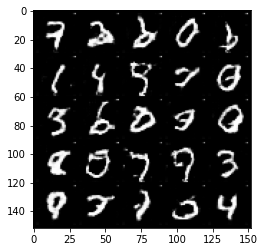

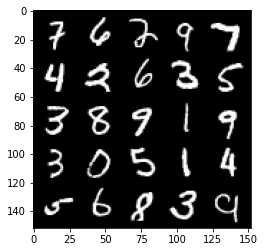

Step 11500: Generator loss: 0.7016425780057909, discriminator loss: 0.690724144101143


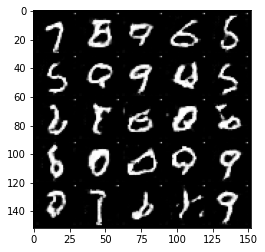

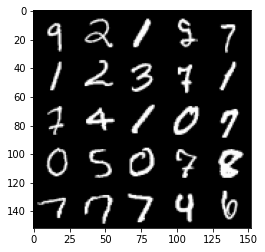

Step 12000: Generator loss: 0.7002939511537556, discriminator loss: 0.6911950635910039


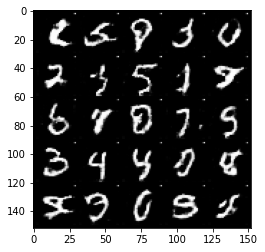

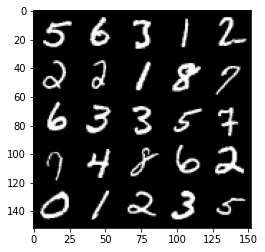

Step 12500: Generator loss: 0.6989934042692193, discriminator loss: 0.6916106235980987


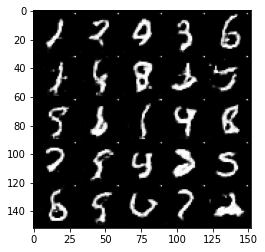

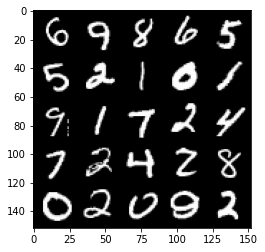

Step 13000: Generator loss: 0.6980480533838277, discriminator loss: 0.6916376739740367


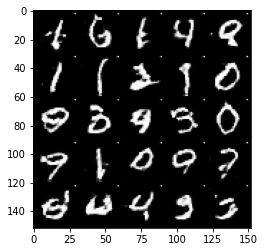

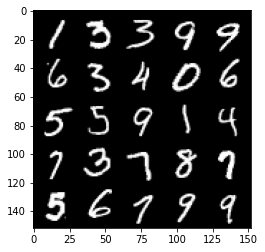

Step 13500: Generator loss: 0.6986095855236053, discriminator loss: 0.6919637193679815


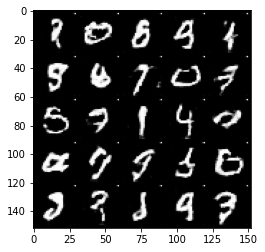

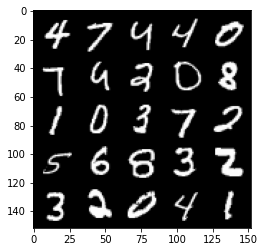

Step 14000: Generator loss: 0.6978214554786686, discriminator loss: 0.6920761320590963


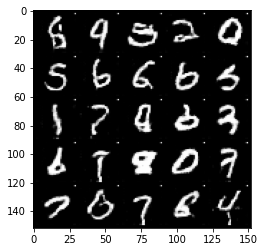

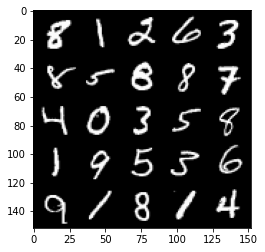

Step 14500: Generator loss: 0.697555611848831, discriminator loss: 0.6924450602531432


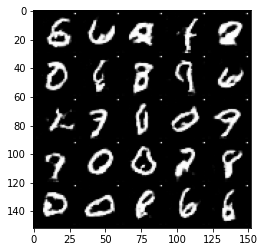

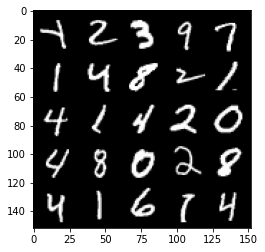

Step 15000: Generator loss: 0.6968094234466558, discriminator loss: 0.6926976927518852


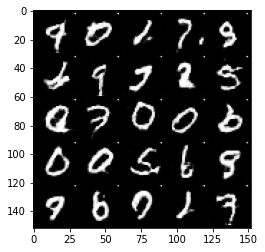

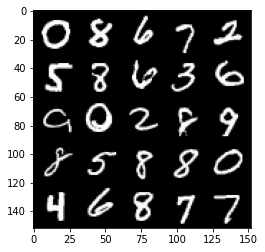

Step 15500: Generator loss: 0.6965010788440694, discriminator loss: 0.6929530932903286


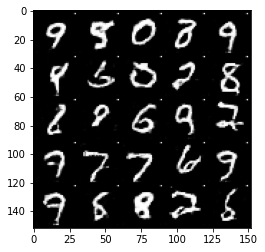

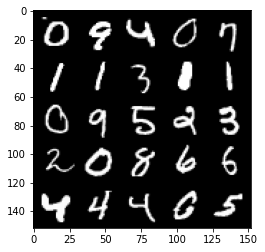

Step 16000: Generator loss: 0.6960302186012274, discriminator loss: 0.6929720265865327


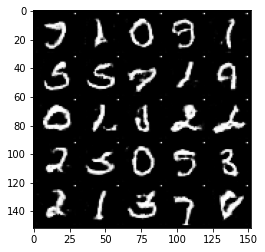

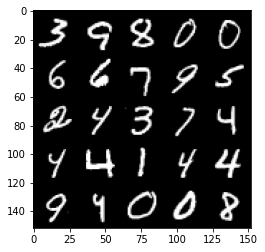

Step 16500: Generator loss: 0.6956665347814561, discriminator loss: 0.6932170706987383


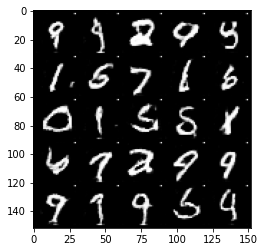

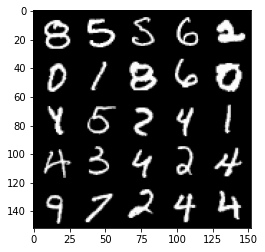

Step 17000: Generator loss: 0.6954577699899682, discriminator loss: 0.6933574808835983


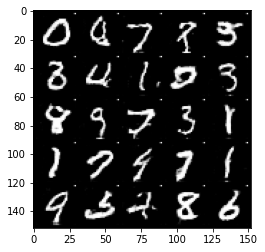

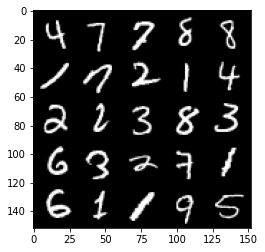

Step 17500: Generator loss: 0.6951234316825864, discriminator loss: 0.6935912373065952


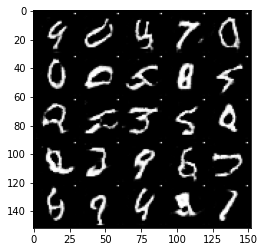

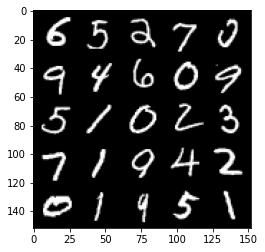

Step 18000: Generator loss: 0.6950048154592519, discriminator loss: 0.6936140552759171


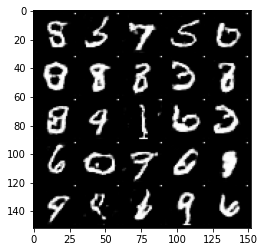

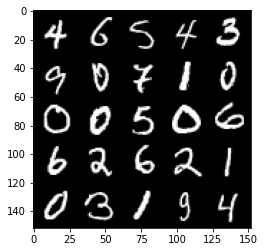

Step 18500: Generator loss: 0.6942454937696458, discriminator loss: 0.6937014592885976


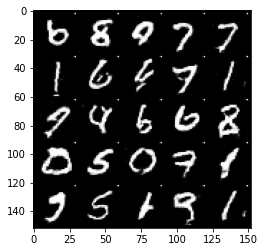

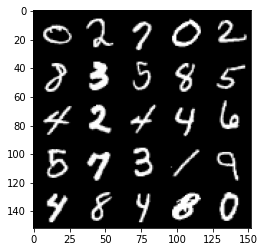

Step 19000: Generator loss: 0.6948429381847384, discriminator loss: 0.6939721192121513


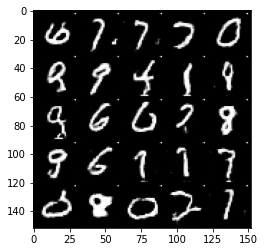

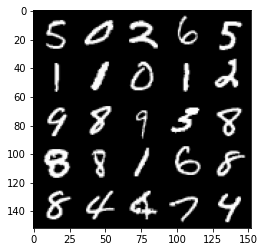

Step 19500: Generator loss: 0.6940645610094066, discriminator loss: 0.6938907772302632


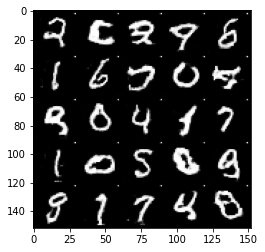

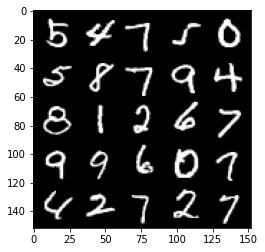

Step 20000: Generator loss: 0.6936006753444672, discriminator loss: 0.6938676849603651


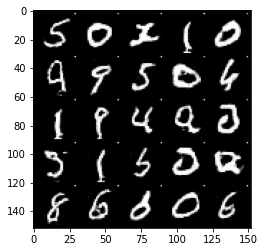

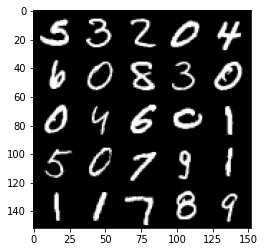

Step 20500: Generator loss: 0.6936275503635408, discriminator loss: 0.6939091728925711


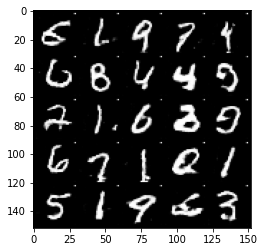

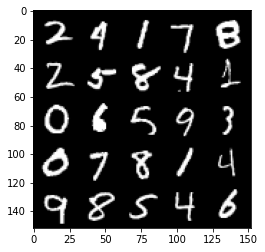

Step 21000: Generator loss: 0.6936945372819897, discriminator loss: 0.6938829227685925


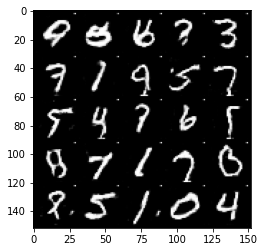

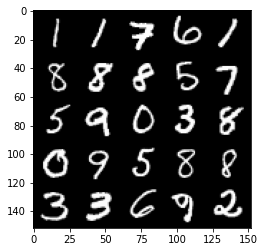

Step 21500: Generator loss: 0.6938780181407922, discriminator loss: 0.6939496351480485


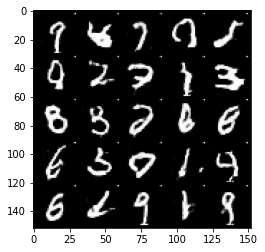

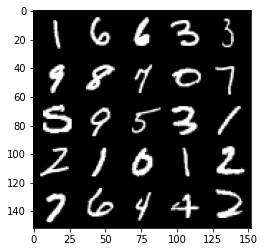

Step 22000: Generator loss: 0.6940483191013341, discriminator loss: 0.6938821079730983


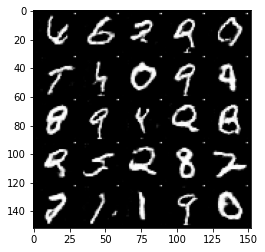

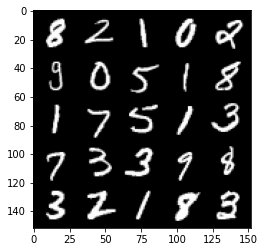

Step 22500: Generator loss: 0.6934497642517097, discriminator loss: 0.6937629218101509


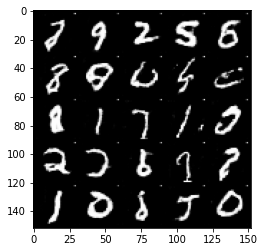

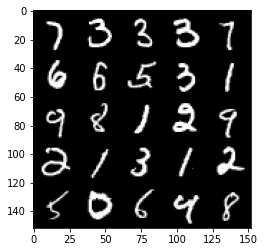

Step 23000: Generator loss: 0.6937578619718551, discriminator loss: 0.6937772518396377


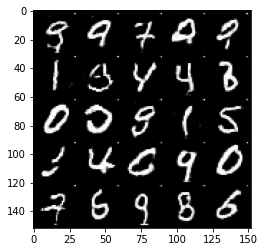

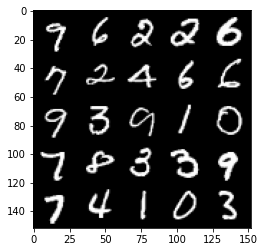

In [ ]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update Discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update Generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1